In [ ]:
import sys
sys.path.append('../')
from success_prediction.config import EXTERNAL_DATA_DIR
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
from seaborn import heatmap

# SODC DATA STRUCTURE ANALYSIS

In [37]:
df = pd.read_csv(EXTERNAL_DATA_DIR / 'sodc_data_summary.csv')

In [84]:
# Find the number of shab entries requiring partial llm-parsing
partial_llm_parsing = df.groupby('shab_id')['llm_parsed'].max().reset_index()
partial_llm_parsing['llm_parsed'].sum()

445393.0

In [86]:
445393 / 2464085

0.18075391068084096

In [85]:
partial_llm_parsing

,shab_id,llm_parsed
0,2636071,1.0
1,2636073,0.0
2,2636075,0.0
3,2636077,0.0
4,2636079,0.0
...,...,...
2464080,1006273239,1.0
2464081,1006273250,1.0
2464082,1006273261,0.0
2464083,1006273283,0.0


In [38]:
year_total = df.groupby(['year', 'language'])['llm_parsed'].count().reset_index()
year_sum = year_total.groupby('year')['llm_parsed'].sum().reset_index().rename(columns={'llm_parsed': 'total'})
year_total = year_total.merge(year_sum, on='year')
year_total['percentage'] = year_total['llm_parsed'] / year_total['total']
year_language = df.groupby(['year', 'language'])['llm_parsed'].mean().reset_index()
canton = df.groupby(['registry_office_canton'])['llm_parsed'].mean().reset_index()
year_canton = df.groupby(['year', 'registry_office_canton'])['llm_parsed'].mean().reset_index()

In [76]:
average_per_language = df.groupby(['language'])['llm_parsed'].mean().reset_index()
average_per_language

,language,llm_parsed
0,de,0.058085
1,fr,0.111148
2,it,0.069025


In [78]:
year_total['llm_parsed'].sum()

7366993

In [79]:
year_total

,year,language,llm_parsed,total,percentage
0,2016,de,471801,657409,0.717667
1,2016,fr,130435,657409,0.198408
2,2016,it,55173,657409,0.083925
3,2017,de,524317,739185,0.709318
4,2017,fr,154186,739185,0.208589
5,2017,it,60682,739185,0.082093
6,2018,de,533876,746577,0.715098
7,2018,fr,156733,746577,0.209935
8,2018,it,55968,746577,0.074966
9,2019,de,558989,776488,0.719894


In [101]:
import numpy as np

mpl.rcParams.update({
    "font.family": "serif",
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10
})

def custom_line_plot(ax, df, x_col, y_col, v_col, add_trend=True):
    pivot_df = df.pivot(index=x_col, columns=y_col, values=v_col)

    for column in pivot_df.columns:
        x = pivot_df.index.values
        y = pivot_df[column].values

        # Plot the actual line
        ax.plot(
            x, y, marker='o', label=column,
            linewidth=1, markersize=2
        )

        # Add trend line (linear fit)
        if add_trend and len(x) > 1 and not np.all(np.isnan(y)):
            # Remove NaNs
            valid = ~np.isnan(y)
            if valid.sum() >= 2:
                coeffs = np.polyfit(x[valid], y[valid], deg=1)
                trend = np.poly1d(coeffs)
                ax.plot(
                    x, trend(x), linestyle='--', linewidth=0.75,
                    alpha=0.5,
                )

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.tick_params(direction='in', top=False, right=False)
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return ax

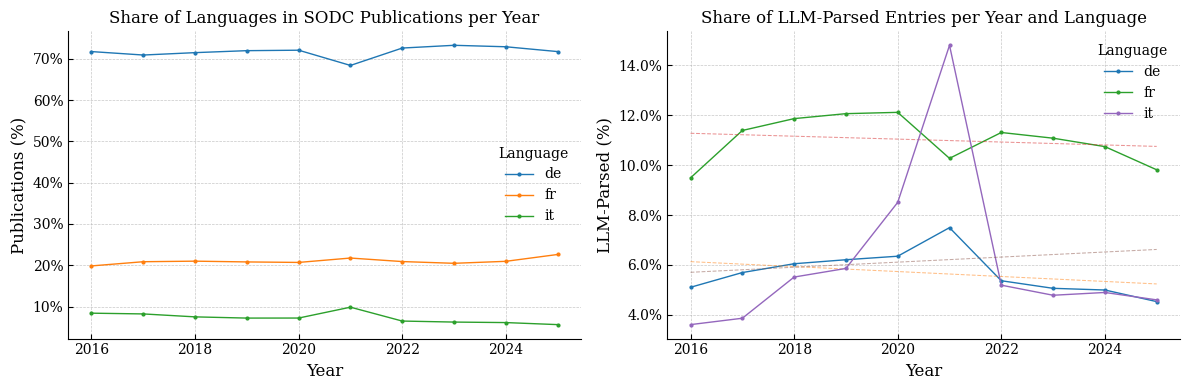

In [102]:
fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)  # Approx A4 column width

axes[0] = custom_line_plot(axes[0], year_total, 'year', 'language', 'percentage', add_trend=False)
axes[1] = custom_line_plot(axes[1], year_language, 'year', 'language', 'llm_parsed')

axes[0].set_title('Share of Languages in SODC Publications per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Publications (%)')
axes[0].legend(title='Language', frameon=False)

axes[1].set_title('Share of LLM-Parsed Entries per Year and Language')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('LLM-Parsed (%)')
axes[1].legend(title='Language', frameon=False)

plt.tight_layout()
plt.savefig('../reports/figures/summary_line_charts.png')

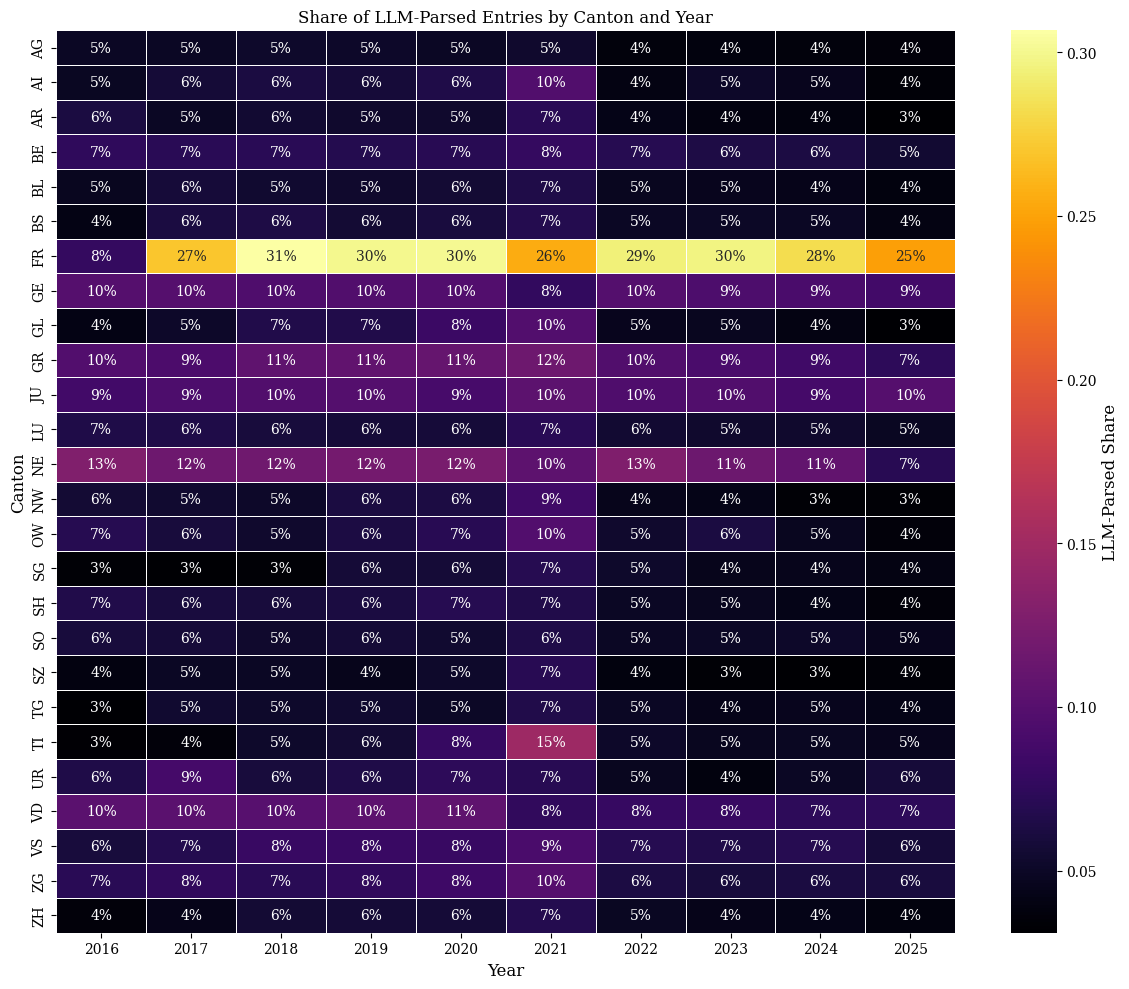

In [72]:
pivot_df = year_canton.pivot(index='registry_office_canton', columns='year', values='llm_parsed')
fig, ax = plt.subplots(figsize=(12, 10))

# Create heatmap
heatmap(
    pivot_df,
    cmap="inferno",  # Clean and journal-appropriate
    ax=ax,
    linewidths=0.5,
    linecolor='white',
    annot=True,             # Annotate cells with values
    fmt=".0%",              # Format as percentage
    cbar_kws={'label': 'LLM-Parsed Share'},
    vmin=min(pivot_df.values.flatten()),
    vmax=max(pivot_df.values.flatten())
)

# Axis labels and formatting
ax.set_title("Share of LLM-Parsed Entries by Canton and Year")
ax.set_xlabel("Year")
ax.set_ylabel("Canton")

# Tight layout for publication
plt.tight_layout()
plt.savefig('../reports/figures/summary_heatmap.png')

# SUMMARY STATISTICS ...